In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import compute_sample_weight

# Get data and pre-process

In [2]:
def delay_to_status(delay):
    if delay < -10:
        return "Early"
    elif -10 <= delay <= 10:
        return "On-time"
    elif 10 < delay <= 30:
        return "Late"
    else:
        return "Severely Late"

In [3]:
DESTINATION_AIRPORT = 'SYR'

# Load the historical data into a pandas dataframe
flight_data = pd.read_csv("data/flight_data.csv", parse_dates=['Date (MM/DD/YYYY)'])
destination_weather_data = pd.read_csv("data/all_destination_weather.csv", parse_dates=['destination_time'])

# Categorize delays
flight_data['Status'] = flight_data['Arrival Delay (Minutes)'].apply(delay_to_status)

# Drop unnecessary columns
flight_data.drop(columns=[
    'Flight Number',
    'Tail Number',
    'Scheduled Arrival Time',
    'Scheduled Elapsed Time (Minutes)',
    'Actual Elapsed Time (Minutes)',
    'Arrival Delay (Minutes)',
    'Wheels-on Time',
    'Taxi-In time (Minutes)',
    'Delay Carrier (Minutes)',
    'Delay Weather (Minutes)',
    'Delay National Aviation System (Minutes)',
    'Delay Security (Minutes)',
    'Delay Late Aircraft Arrival (Minutes)'
], inplace=True)

# Handle missing values
flight_data.dropna(inplace=True)

# Show 10 rows of the dataframe
flight_data.head()

,Date (MM/DD/YYYY),Origin Airport,Actual Arrival Time,Status
0,1988-01-01,ORD,19:13,Early
1,1988-01-01,ORD,22:41,On-time
2,1989-01-01,ORD,18:27,Severely Late
3,1989-01-01,ORD,20:55,Severely Late
4,1989-01-01,ORD,9:00,On-time


# Get Date Ranges for Weather Data

In [4]:
# Group flight_data by 'Origin Airport' and aggregate the min and max 'Departure Datetime' for each group
date_ranges = flight_data.groupby('Origin Airport')['Date (MM/DD/YYYY)'].agg(['min', 'max'])

# Print the 'Origin Airport' and the date range for each group
for index, row in date_ranges.iterrows():
    adjusted_min = row['min'] - pd.Timedelta(days=1)
    adjusted_max = row['max'] + pd.Timedelta(days=1)
    print(f"Origin Airport: {index}")
    print(f"Adjusted Date Range: {adjusted_min.strftime('%Y-%m-%d')} - {adjusted_max.strftime('%Y-%m-%d')}\n")

min_departure = flight_data['Date (MM/DD/YYYY)'].min() - pd.Timedelta(days=1)
max_departure = flight_data['Date (MM/DD/YYYY)'].max() + pd.Timedelta(days=1)

print(
    f"Overall Adjusted Date Range: {min_departure.strftime('%Y-%m-%d')} - {max_departure.strftime('%Y-%m-%d')}")

Origin Airport: DEN
Adjusted Date Range: 2022-02-10 - 2023-02-01

Origin Airport: EWR
Adjusted Date Range: 2019-11-29 - 2023-02-01

Origin Airport: IAD
Adjusted Date Range: 1988-06-08 - 2023-01-03

Origin Airport: ORD
Adjusted Date Range: 1987-09-30 - 2023-02-01

Overall Adjusted Date Range: 1987-09-30 - 2023-02-01


# Feature Engineering

## Add Arrival Datetime

In [5]:
# Create a boolean mask to identify rows with '24:00:00'
mask_24 = flight_data['Actual Arrival Time'] == '24:00:00'

# Replace '24:00:00' with '00:00:00'
flight_data['Actual Arrival Time'] = flight_data['Actual Arrival Time'].replace('24:00:00', '00:00:00')

# Combine date and time columns
flight_data['Arrival Datetime'] = pd.to_datetime(
    flight_data['Date (MM/DD/YYYY)'].astype(str) + ' ' + flight_data['Actual Arrival Time'])

# Add a day to the date part when the original time value was '24:00:00'
flight_data.loc[mask_24, 'Arrival Datetime'] = flight_data.loc[mask_24, 'Arrival Datetime'] + pd.Timedelta(days=1)

# Drop more unnecessary date columns
flight_data.drop(columns=[
    'Date (MM/DD/YYYY)',
    'Actual Arrival Time',
], inplace=True)

# Round to the nearest hour for the weather data
flight_data['Arrival Datetime'] = flight_data['Arrival Datetime'].dt.round("H")

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Status,Arrival Datetime
0,ORD,Early,1988-01-01 19:00:00
1,ORD,On-time,1988-01-01 23:00:00
2,ORD,Severely Late,1989-01-01 18:00:00
3,ORD,Severely Late,1989-01-01 21:00:00
4,ORD,On-time,1989-01-01 09:00:00
5,ORD,Severely Late,1989-01-02 00:00:00
6,IAD,Severely Late,1989-01-01 15:00:00
7,IAD,Severely Late,1989-01-02 00:00:00
8,ORD,Late,1990-01-01 17:00:00
9,ORD,On-time,1990-01-01 23:00:00


## Time of day
Flights during certain times of the day may experience more delays, such as early morning or late evening flights.

In [6]:
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


flight_data['Time of Day'] = flight_data['Arrival Datetime'].dt.hour.apply(categorize_time_of_day)

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Status,Arrival Datetime,Time of Day
0,ORD,Early,1988-01-01 19:00:00,Evening
1,ORD,On-time,1988-01-01 23:00:00,Night
2,ORD,Severely Late,1989-01-01 18:00:00,Evening
3,ORD,Severely Late,1989-01-01 21:00:00,Night
4,ORD,On-time,1989-01-01 09:00:00,Morning
5,ORD,Severely Late,1989-01-02 00:00:00,Night
6,IAD,Severely Late,1989-01-01 15:00:00,Afternoon
7,IAD,Severely Late,1989-01-02 00:00:00,Night
8,ORD,Late,1990-01-01 17:00:00,Evening
9,ORD,On-time,1990-01-01 23:00:00,Night


## Day of the week
Some days of the week may have more delays than others, such as weekends or Fridays, when air traffic is typically higher.

In [7]:
flight_data['Day of the Week'] = flight_data['Arrival Datetime'].dt.dayofweek
flight_data['Day of the Week'] = flight_data['Day of the Week'].astype('category')

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Status,Arrival Datetime,Time of Day,Day of the Week
0,ORD,Early,1988-01-01 19:00:00,Evening,4
1,ORD,On-time,1988-01-01 23:00:00,Night,4
2,ORD,Severely Late,1989-01-01 18:00:00,Evening,6
3,ORD,Severely Late,1989-01-01 21:00:00,Night,6
4,ORD,On-time,1989-01-01 09:00:00,Morning,6
5,ORD,Severely Late,1989-01-02 00:00:00,Night,0
6,IAD,Severely Late,1989-01-01 15:00:00,Afternoon,6
7,IAD,Severely Late,1989-01-02 00:00:00,Night,0
8,ORD,Late,1990-01-01 17:00:00,Evening,0
9,ORD,On-time,1990-01-01 23:00:00,Night,0


## Month and season
Delays may be more common during certain months or seasons, such as winter months with more severe weather.

In [8]:
# Add the 'Month' feature
flight_data['Month'] = flight_data['Arrival Datetime'].dt.month
flight_data['Month'] = flight_data['Month'].astype('category')


def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'


# Add the 'Season' feature
flight_data['Season'] = flight_data['Month'].apply(month_to_season)
flight_data['Season'] = flight_data['Season'].astype('category')

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season
0,ORD,Early,1988-01-01 19:00:00,Evening,4,1,Winter
1,ORD,On-time,1988-01-01 23:00:00,Night,4,1,Winter
2,ORD,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter
3,ORD,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter
4,ORD,On-time,1989-01-01 09:00:00,Morning,6,1,Winter
5,ORD,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter
6,IAD,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter
7,IAD,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter
8,ORD,Late,1990-01-01 17:00:00,Evening,0,1,Winter
9,ORD,On-time,1990-01-01 23:00:00,Night,0,1,Winter


## Flight route
Some flight routes may be more prone to delays than others due to factors such as air traffic congestion, distance, or regional weather patterns.

In [9]:
flight_data['Flight Route'] = flight_data['Origin Airport'] + '-' + DESTINATION_AIRPORT
flight_data['Flight Route'] = flight_data['Flight Route'].astype('category')

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route
0,ORD,Early,1988-01-01 19:00:00,Evening,4,1,Winter,ORD-SYR
1,ORD,On-time,1988-01-01 23:00:00,Night,4,1,Winter,ORD-SYR
2,ORD,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter,ORD-SYR
3,ORD,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter,ORD-SYR
4,ORD,On-time,1989-01-01 09:00:00,Morning,6,1,Winter,ORD-SYR
5,ORD,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,ORD-SYR
6,IAD,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter,IAD-SYR
7,IAD,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,IAD-SYR
8,ORD,Late,1990-01-01 17:00:00,Evening,0,1,Winter,ORD-SYR
9,ORD,On-time,1990-01-01 23:00:00,Night,0,1,Winter,ORD-SYR


## Distance between origin and destination airports
The distance between airports could affect the likelihood of delays due to various factors, such as air traffic or weather conditions along the route.

In [10]:
cords = {
    'IATA': ['SYR', 'EWR', 'ORD', 'IAD', 'DEN'],
    'Latitude': [43.1112, 40.6925, 41.9742, 38.9445, 39.8617],
    'Longitude': [-76.1038, -74.1687, -87.9073, -77.4558, -104.6731]
}

airport_coords = pd.DataFrame(cords)
airport_coords.set_index('IATA', inplace=True)


def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


def get_distance(row, airport_coords):
    origin_airport = row['Origin Airport']

    origin_coords = airport_coords.loc[origin_airport]
    dest_coords = airport_coords.loc[DESTINATION_AIRPORT]

    distance = haversine(origin_coords['Latitude'], origin_coords['Longitude'],
                         dest_coords['Latitude'], dest_coords['Longitude'])
    return round(distance)


# Assuming airport_coords is a dataframe indexed by IATA code with 'Latitude' and 'Longitude' columns
flight_data['Distance (km)'] = flight_data.apply(lambda row: get_distance(row, airport_coords), axis=1)

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Status,Arrival Datetime,Time of Day,Day of the Week,Month,Season,Flight Route,Distance (km)
0,ORD,Early,1988-01-01 19:00:00,Evening,4,1,Winter,ORD-SYR,974
1,ORD,On-time,1988-01-01 23:00:00,Night,4,1,Winter,ORD-SYR,974
2,ORD,Severely Late,1989-01-01 18:00:00,Evening,6,1,Winter,ORD-SYR,974
3,ORD,Severely Late,1989-01-01 21:00:00,Night,6,1,Winter,ORD-SYR,974
4,ORD,On-time,1989-01-01 09:00:00,Morning,6,1,Winter,ORD-SYR,974
5,ORD,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,ORD-SYR,974
6,IAD,Severely Late,1989-01-01 15:00:00,Afternoon,6,1,Winter,IAD-SYR,477
7,IAD,Severely Late,1989-01-02 00:00:00,Night,0,1,Winter,IAD-SYR,477
8,ORD,Late,1990-01-01 17:00:00,Evening,0,1,Winter,ORD-SYR,974
9,ORD,On-time,1990-01-01 23:00:00,Night,0,1,Winter,ORD-SYR,974


## Destination Weather Data

In [11]:
# Merge the merged_data and destination_weather_data dataframes on 'Arrival Datetime', and 'destination_time' columns using a left join
data = pd.merge(flight_data, destination_weather_data,
                left_on='Arrival Datetime',
                right_on='destination_time',
                how='left')

# Drop more unnecessary columns
data.drop(columns=[
    'Origin Airport',
    'Arrival Datetime',
    'destination_time',
], inplace=True)

# Show 10 rows of the dataframe
data.head(10)

,Status,Time of Day,Day of the Week,Month,Season,Flight Route,Distance (km),destination_temperature_2m (°C),destination_relativehumidity_2m (%),destination_dewpoint_2m (°C),...,destination_snowfall (cm),destination_cloudcover (%),destination_cloudcover_low (%),destination_cloudcover_mid (%),destination_cloudcover_high (%),destination_windspeed_10m (km/h),destination_winddirection_10m (°),destination_windgusts_10m (km/h),destination_et0_fao_evapotranspiration (mm),destination_vapor_pressure_deficit (kPa)
0,Early,Evening,4,1,Winter,ORD-SYR,974,-3.2,67,-8.5,...,0.00,77,79,9,0,15.4,254,31.7,0.02,0.16
1,On-time,Night,4,1,Winter,ORD-SYR,974,-4.5,63,-10.5,...,0.00,90,89,16,0,17.2,259,38.9,0.02,0.16
2,Severely Late,Evening,6,1,Winter,ORD-SYR,974,-0.8,80,-3.8,...,0.00,52,42,24,0,9.7,141,21.2,0.01,0.12
3,Severely Late,Night,6,1,Winter,ORD-SYR,974,-0.6,76,-4.3,...,0.00,100,85,21,63,14.9,173,31.3,0.01,0.14
4,On-time,Morning,6,1,Winter,ORD-SYR,974,-11.8,89,-13.3,...,0.00,38,8,45,11,10.0,120,18.4,0.00,0.03
5,Severely Late,Night,0,1,Winter,ORD-SYR,974,0.0,80,-3.0,...,0.00,95,71,4,94,15.8,180,34.2,0.01,0.12
6,Severely Late,Afternoon,6,1,Winter,IAD-SYR,477,1.1,62,-5.4,...,0.00,17,17,2,0,10.6,145,24.1,0.11,0.25
7,Severely Late,Night,0,1,Winter,IAD-SYR,477,0.0,80,-3.0,...,0.00,95,71,4,94,15.8,180,34.2,0.01,0.12
8,Late,Evening,0,1,Winter,ORD-SYR,974,-4.2,74,-8.2,...,0.07,87,83,20,0,21.6,294,51.5,0.03,0.12
9,On-time,Night,0,1,Winter,ORD-SYR,974,-5.0,80,-7.9,...,0.07,79,88,0,0,16.3,298,37.8,0.01,0.08


# Check Data

Status                                           object
Time of Day                                      object
Day of the Week                                category
Month                                          category
Season                                         category
Flight Route                                   category
Distance (km)                                     int64
destination_temperature_2m (°C)                 float64
destination_relativehumidity_2m (%)               int64
destination_dewpoint_2m (°C)                    float64
destination_apparent_temperature (°C)           float64
destination_pressure_msl (hPa)                  float64
destination_surface_pressure (hPa)              float64
destination_precipitation (mm)                  float64
destination_rain (mm)                           float64
destination_snowfall (cm)                       float64
destination_cloudcover (%)                        int64
destination_cloudcover_low (%)                  

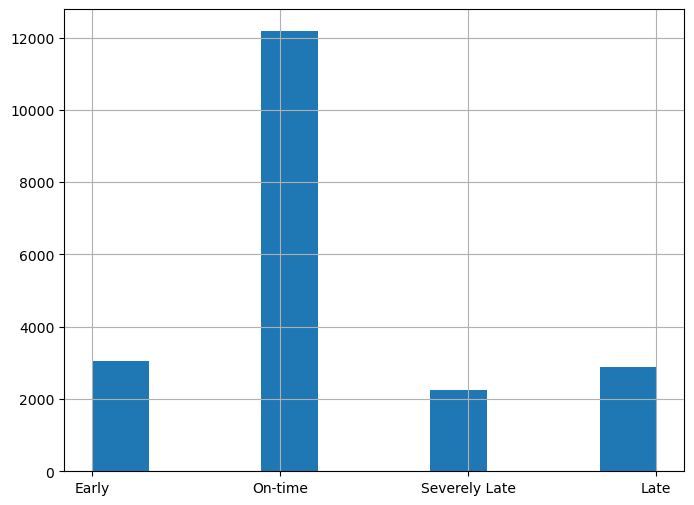

Length of flight data:  20352
Length of merged data:  20352
Total NaN values:  0


In [12]:
display(data.dtypes)

fig, ax = plt.subplots(figsize=(8, 6))
data['Status'].hist(ax=ax)
plt.show()

print("Length of flight data: ", len(flight_data))
print("Length of merged data: ", len(data))
print("Total NaN values: ", data.isna().sum().sum())

# One Hot Encoding

In [13]:
# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Day of the Week', 'Time of Day', 'Month', 'Season', 'Flight Route'],
                      drop_first=True)

# Show 10 rows of the dataframe
data.head(10)

,Status,Distance (km),destination_temperature_2m (°C),destination_relativehumidity_2m (%),destination_dewpoint_2m (°C),destination_apparent_temperature (°C),destination_pressure_msl (hPa),destination_surface_pressure (hPa),destination_precipitation (mm),destination_rain (mm),...,Month_9,Month_10,Month_11,Month_12,Season_Spring,Season_Summer,Season_Winter,Flight Route_EWR-SYR,Flight Route_IAD-SYR,Flight Route_ORD-SYR
0,Early,974,-3.2,67,-8.5,-8.6,1023.8,1006.5,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
1,On-time,974,-4.5,63,-10.5,-10.3,1025.3,1007.9,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
2,Severely Late,974,-0.8,80,-3.8,-4.8,1018.6,1001.5,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
3,Severely Late,974,-0.6,76,-4.3,-5.5,1018.9,1001.8,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
4,On-time,974,-11.8,89,-13.3,-16.8,1024.4,1006.5,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
5,Severely Late,974,0.0,80,-3.0,-4.8,1016.6,999.6,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
6,Severely Late,477,1.1,62,-5.4,-3.3,1019.9,1002.9,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0
7,Severely Late,477,0.0,80,-3.0,-4.8,1016.6,999.6,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0
8,Late,974,-4.2,74,-8.2,-10.5,1013.7,996.5,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
9,On-time,974,-5.0,80,-7.9,-10.4,1021.7,1004.3,0.1,0.0,...,0,0,0,0,0,0,1,0,0,1


# Split data into testing and training

In [14]:
X = data.drop(columns=['Status'])
y = data['Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the length of the train and test data
print("Length of train dataset: ", len(X_train))
print("Length of test dataset: ", len(X_test))

Length of train dataset:  16281
Length of test dataset:  4071


# Normalize data

In [15]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Show 10 rows of the dataframe
X_train.head(10)

,Distance (km),destination_temperature_2m (°C),destination_relativehumidity_2m (%),destination_dewpoint_2m (°C),destination_apparent_temperature (°C),destination_pressure_msl (hPa),destination_surface_pressure (hPa),destination_precipitation (mm),destination_rain (mm),destination_snowfall (cm),...,Month_9,Month_10,Month_11,Month_12,Season_Spring,Season_Summer,Season_Winter,Flight Route_EWR-SYR,Flight Route_IAD-SYR,Flight Route_ORD-SYR
14100,0.078770,0.679868,1.000000,0.827138,0.686331,0.537736,0.556802,0.204819,0.204819,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9830,0.317483,0.768977,0.476744,0.754647,0.725180,0.599730,0.624123,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16218,0.317483,0.526403,0.546512,0.527881,0.494964,0.676550,0.691445,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16870,0.317483,0.567657,0.697674,0.620818,0.539568,0.467655,0.479663,0.012048,0.012048,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7831,0.317483,0.673267,0.686047,0.730483,0.671942,0.525606,0.544180,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4073,0.317483,0.445545,0.906977,0.542751,0.408633,0.672507,0.683029,0.132530,0.084337,0.137931,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5084,0.317483,0.488449,0.627907,0.513011,0.470504,0.722372,0.736325,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1965,0.317483,0.386139,0.802326,0.453532,0.358273,0.598383,0.604488,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
18400,0.317483,0.448845,0.744186,0.505576,0.410072,0.574124,0.583450,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11829,0.317483,0.818482,0.895349,0.957249,0.869065,0.520216,0.545582,0.012048,0.012048,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Hyperparameter tuning

In [16]:
# Instantiate the LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable in the training set
y_train_encoded = le.fit_transform(y_train)

# Transform the target variable in the testing set
y_test_encoded = le.transform(y_test)

# Calculate the sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Define the parameter grid for the search
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [7, 9, 11],
    'learning_rate': [0.2, 0.3, 0.4],
}

# Create the XGBClassifier instance
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', seed=42)

# Create the GridSearchCV instance
grid_search = GridSearchCV(xgb_clf, param_grid, scoring='f1_weighted', cv=3, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train_encoded, sample_weight=sample_weights)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[10:34:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 3}


# Training the best model

In [17]:
# Create and train the XGBoost model
xgbr = xgb.XGBClassifier(objective='multi:softmax', seed=42, **best_params)
xgbr.fit(X_train, y_train_encoded, sample_weight=sample_weights)

# Make predictions
y_train_pred_encoded = xgbr.predict(X_train)
y_test_pred_encoded = xgbr.predict(X_test)

# Inverse transform the predictions back to the original labels
y_train_pred = le.inverse_transform(y_train_pred_encoded)
y_test_pred = le.inverse_transform(y_test_pred_encoded)

[10:34:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



# Evaluate the model

In [18]:
print('Training Classification report:')
print(classification_report(y_train, y_train_pred))

print('\nTesting Classification report:')
print(classification_report(y_test, y_test_pred))

Training Classification report:
               precision    recall  f1-score   support

        Early       0.96      1.00      0.98      2437
         Late       0.97      1.00      0.98      2302
      On-time       1.00      0.97      0.99      9740
Severely Late       0.94      1.00      0.97      1802

     accuracy                           0.98     16281
    macro avg       0.97      0.99      0.98     16281
 weighted avg       0.98      0.98      0.98     16281


Testing Classification report:
               precision    recall  f1-score   support

        Early       0.21      0.16      0.18       610
         Late       0.26      0.18      0.21       575
      On-time       0.64      0.72      0.68      2436
Severely Late       0.28      0.28      0.28       450

     accuracy                           0.51      4071
    macro avg       0.35      0.34      0.34      4071
 weighted avg       0.48      0.51      0.49      4071



In [19]:
test_output = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred})

test_output.head(30)

,actual,predicted
13435,On-time,On-time
7552,On-time,Severely Late
6981,On-time,Early
7257,On-time,On-time
4813,On-time,On-time
2013,On-time,Early
14330,On-time,On-time
7137,Late,Late
15933,On-time,Early
10742,Late,Late


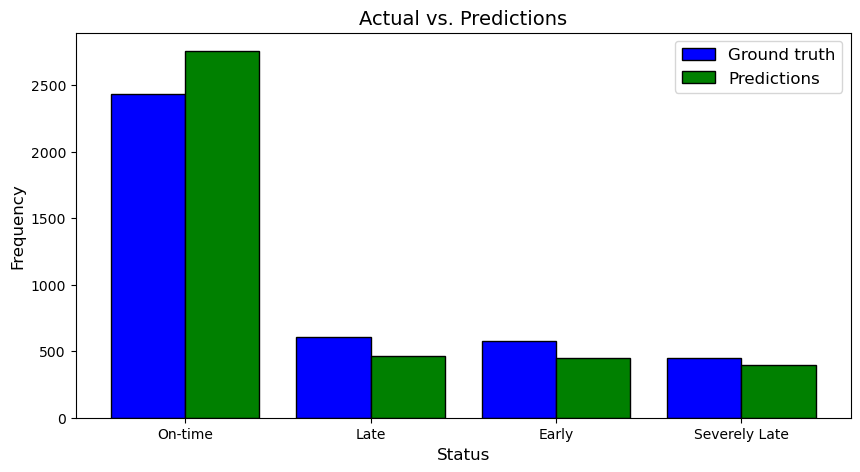

In [20]:
# Create a single figure with a specified size (width=10, height=5)
fig, ax = plt.subplots(figsize=(10, 5))

# Set the width of the bars in the histogram
bar_width = 0.4

# Create an array with the unique categories in the 'actual' and 'predicted' columns
categories = test_output.actual.unique()

# Generate the x-axis positions for each category
x_pos = np.arange(len(categories))

# Calculate the counts for each category in the 'actual' column
actual_counts = test_output.actual.value_counts()

# Calculate the counts for each category in the 'predicted' column
predicted_counts = test_output.predicted.value_counts()

# Plot the histogram of the ground truth (actual) values
ax.bar(x_pos - bar_width / 2, actual_counts, width=bar_width, color='blue', edgecolor='black', label='Ground truth')

# Plot the histogram of the predicted values
ax.bar(x_pos + bar_width / 2, predicted_counts, width=bar_width, color='green', edgecolor='black', label='Predictions')

# Set the x-axis ticks and labels
ax.set_xticks(x_pos)
ax.set_xticklabels(categories)

# Set the title and axis labels for the figure
ax.set_title('Actual vs. Predictions', fontsize=14)
ax.set_xlabel('Status', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add a legend to distinguish between the two sets of data
ax.legend(fontsize=12)

# Display the figure
plt.show()

In [21]:
# Load the historical data into a pandas dataframe
test_data = pd.read_csv("data/test_data.csv", parse_dates=['Date'])

# Drop unnecessary columns
test_data.drop(columns=[
    'Flight Number',
    'Status (Early, On-time, Late, Severly Late)',
], inplace=True)

test_data.head(20)

,Date,Day,Origin Airport,Arrival Time
0,2023-04-21,Friday,ORD,10:00 AM
1,2023-04-21,Friday,ORD,4:50 PM
2,2023-04-21,Friday,ORD,9:34 PM
3,2023-04-22,Saturday,ORD,10:00 AM
4,2023-04-22,Saturday,ORD,4:50 PM
5,2023-04-22,Saturday,ORD,9:34 PM
6,2023-04-23,Sunday,ORD,10:00 AM
7,2023-04-23,Sunday,ORD,4:55 PM
8,2023-04-23,Sunday,ORD,9:34 PM
9,2023-04-24,Monday,ORD,10:00 AM
